In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
import scipy
import umap
import copy

from models import JacobianCI
from methods import Hexagon, HexagonalGCs

In [3]:
dtype = torch.float32
model = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)

for _ in tqdm.trange(5000):
    rs = model.unit_cell.sample(2**8)
    rs = torch.tensor(rs,dtype=dtype)
    loss = model.train_step(rs)
loss

100%|██████████| 5000/5000 [00:05<00:00, 846.09it/s]


9.767756048439935e-12

In [4]:
def hex_radius(phases, model):
    cdists = np.stack([model.unit_cell.geodesic(phases[i:i+1],phases) for i in range(len(phases))])
    off_diag_mask = ~np.eye(cdists.shape[0],dtype=bool)
    return np.mean(cdists[off_diag_mask]), np.std(cdists[off_diag_mask])

def hex_orientation(phases, model, degrees=True):
    # mirror x and y since arctan2 takes y as first argument and x as second
    angles = np.stack([np.arctan2(*(model.unit_cell.wrap(phases - phases[i]))[:,::-1].T) 
                       for i in range(len(phases))])
    # modulo 60 degrees
    angles = angles % (np.pi/3)
    angles = angles * 180/np.pi if degrees else angles
    off_diag_mask = ~np.eye(phases.shape[0],dtype=bool)
    return np.mean(angles[off_diag_mask]), np.std(angles[off_diag_mask]) 

In [5]:
inscribed_hexagon = Hexagon(hex_radius(model.phases.detach().numpy(), model)[0], hex_orientation(model.phases.detach().numpy(), model)[0], np.zeros(2))
inscribed_hexagon.hpoints

array([[ 0.42857143,  0.08247861],
       [ 0.14285714,  0.41239305],
       [-0.28571429,  0.32991444],
       [-0.42857143, -0.08247861],
       [-0.14285714, -0.41239305],
       [ 0.28571429, -0.32991444]])

In [189]:
rs = [np.zeros(2,dtype=np.float32)]
activities = [model(torch.from_numpy(rs[-1][None])).detach().numpy().squeeze()]
throttle = torch.tensor(model.unit_cell.basis[1]*2, dtype=dtype)
Js = []
dt = 1e-3
start,stop = 0, np.linalg.norm(model.unit_cell.basis[0])*2
ntimesteps = len(np.arange(start, 1, dt))
for i in range(ntimesteps):
    rs.append(rs[-1] + dt * throttle.numpy())  # Convert throttle to numpy
    current_J = model.jacobian(torch.from_numpy(rs[-1][None])).detach().numpy().squeeze()
    Js.append(current_J)
    current_activity = activities[-1]
    next_activity = current_activity + dt * (current_J @ throttle.numpy()) / np.sqrt(model.scale.detach().numpy())  # Convert throttle to numpy
    activities.append(next_activity)
rs = np.stack(rs)
activities = np.stack(activities)
rs.shape, activities.shape

((1001, 2), (1001, 7))

In [207]:
pert.shape, rs[0:1].shape

((10, 2), (1, 2))

In [226]:
pert = np.linspace(0, 2*np.pi, 10)
pert = np.stack([np.cos(pert), np.sin(pert)],axis=-1).astype(np.float32)
Js = model.jacobian(torch.from_numpy(rs[0:1] + pert)).detach().numpy().squeeze()
Js.shape

(10, 7, 2)

In [227]:
[scipy.spatial.distance.cosine(Js[0,:,0], Js[i,:,0]) for i in range(1,10)]

[1.1646745651960373,
 0.8639222830533981,
 1.6666666865348816,
 0.47432100772857666,
 0.4743209481239319,
 1.6666666865348816,
 0.8639225661754608,
 1.164674535393715,
 0]

In [192]:
np.diff(Js, axis=0)

array([[[ 0.00319767, -0.00369263],
        [ 0.01235521,  0.00620764],
        [ 0.00243366,  0.00729561],
        ...,
        [-0.01108825, -0.00565159],
        [-0.00631177,  0.00288868],
        [ 0.0012815 , -0.00749373]],

       [[ 0.00312972, -0.00373447],
        [ 0.01237035,  0.00623596],
        [ 0.00247955,  0.00728106],
        ...,
        [-0.01104474, -0.00561965],
        [-0.00636017,  0.00284481],
        [ 0.00131905, -0.00750113]],

       [[ 0.00306153, -0.00377595],
        [ 0.0123837 ,  0.00626224],
        [ 0.00252604,  0.00726759],
        ...,
        [-0.01100087, -0.00558734],
        [-0.00640821,  0.00280046],
        [ 0.00135708, -0.00750887]],

       ...,

       [[ 0.00346851, -0.00352454],
        [ 0.01229143,  0.00609541],
        [ 0.00224668,  0.00734621],
        ...,
        [-0.01125866, -0.005777  ],
        [-0.00611556,  0.00306511],
        [ 0.00112891, -0.00745964]],

       [[ 0.00340128, -0.00356662],
        [ 0.01230836,  0.00

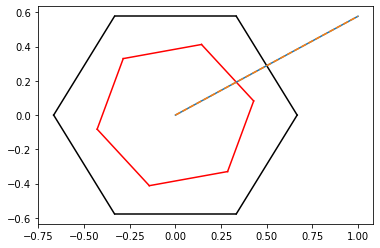

In [183]:
fig, ax = model.unit_cell.plot(color='black')
inscribed_hexagon.plot(fig, ax, color='red')
# plot throttle
ax.plot(*np.array([np.zeros(2), throttle.detach().numpy()]).T)
ax.plot(*rs.T, ls='--')

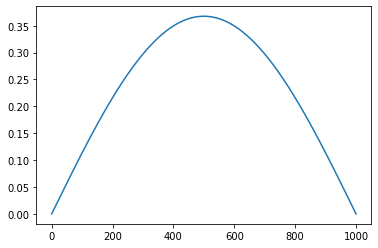

In [184]:
plt.plot(np.linalg.norm(activities - activities[0], axis=1))

In [185]:
forward_activities = model(torch.from_numpy(rs)).detach().numpy() / np.sqrt(model.scale.detach().numpy())
print("dist in space", np.linalg.norm(model.unit_cell.basis[0])*2)
print("dist in neural space", np.linalg.norm(np.diff(forward_activities,axis=0),axis=1).sum())
print("dist in integrated neural space", np.linalg.norm(np.diff(activities, axis=0),axis=1).sum())

dist in space 1.1547005383792515
dist in neural space 1.154691
dist in integrated neural space 1.1547008


In [186]:
# umap the activities
reducer = umap.UMAP(n_components=3, n_neighbors=300)
embedding = reducer.fit_transform(activities)
embedding.shape

(1001, 3)

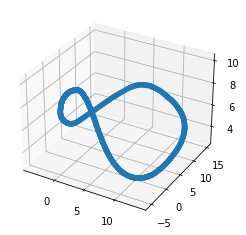

In [187]:
# 3D plot the activities
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*embedding.T)
plt.show()

In [188]:
import plotly.graph_objects as go

# 3D plot the activities
fig = go.Figure(data=[go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode='markers',
    marker=dict(
        size=6,
        color=embedding[:,2],  # set color to third dimension
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [237]:
model.jacobian(torch.from_numpy(rs)).detach().numpy().shape

(1001, 7, 2)

In [243]:
model.jacobian(torch.from_numpy(mesh)).detach().numpy().shape

(10000, 7, 2)

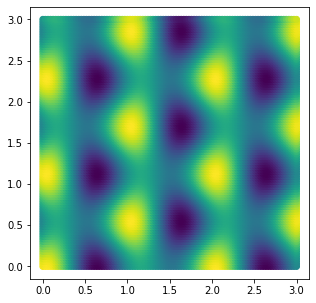

In [257]:
fig,ax = plt.subplots(figsize=(5,5))
mesh = np.linspace(0, 3, 100)
mesh = np.meshgrid(mesh, mesh)
mesh = np.stack([mesh[0].ravel(), mesh[1].ravel()],axis=-1).astype(np.float32)
ax.scatter(*mesh.T, c=model.jacobian(torch.from_numpy(mesh)).detach().numpy()[:,0,0])
#plt.axis('equal')